In [1]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import Model, losses, optimizers, layers
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

import warnings 
import albumentations as albu
warnings.filterwarnings('ignore')

## GPU Settings
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None

tensorflow version:  2.16.1


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using 2 GPUs


In [2]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [4]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


In [5]:
df = pd.read_csv('/kaggle/input/cxr-nih-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*', '*'))}    
    
df['path'] = df['Image Index'].map(tmp)

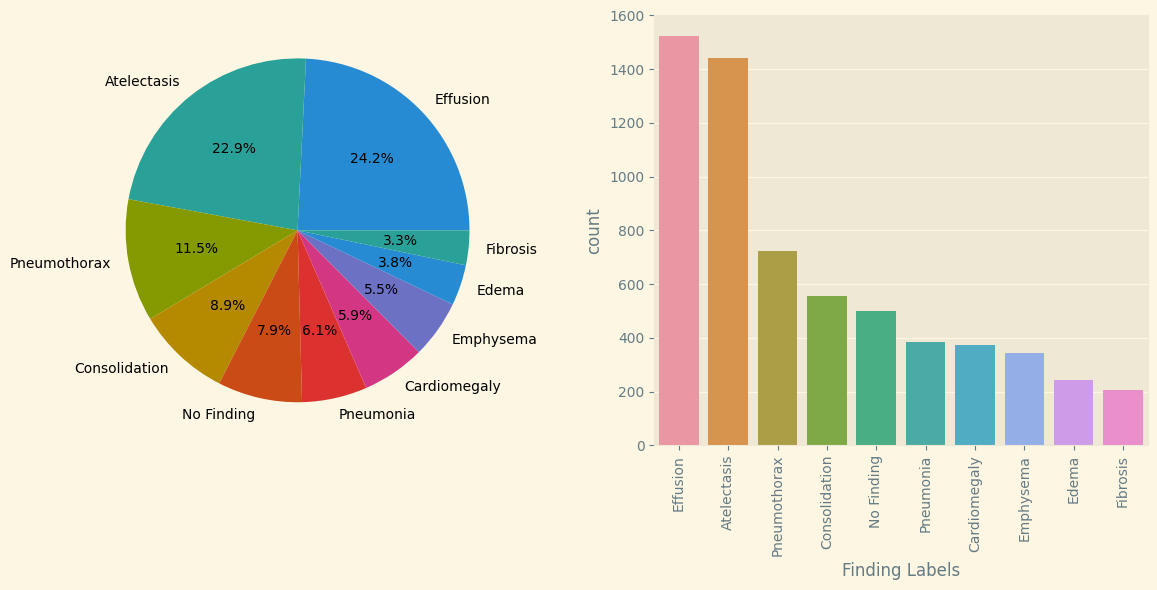

In [6]:
label_counts = df['Finding Labels'].str.split('|').explode().value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].str.split('|').explode().value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'].str.split('|').explode(), order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**Hierachy Multi Label**

![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F16438831%2F49691b45cfbae15dc24da27f175919a7%2Fhmc2.JPG?generation=1725583104709054&alt=media)

In [7]:
def parent_level(row):
    if row in ['No Finding']:
        return 'Parent_No Finding'
    elif row in ['Edema','Atelectasis','Pneumonia','Emphysema','Consolidation','Fibrosis']:
        return 'Parent_Lung Opacity'
    elif row in ['Pneumothorax','Effusion']:
        return 'Parent_Pleural'
    else:
        return 'Parent_Cardiomegaly'

In [8]:
tmp = df['Finding Labels'].str.split('|').explode().apply(lambda x: parent_level(x))
tmp2 = tmp.groupby(tmp.index).agg(lambda x: '|'.join(x))
df['Parent Labels'] = tmp2

In [9]:
for label in ['Parent_No Finding', 'Parent_Lung Opacity', 'Parent_Pleural', 'Parent_Cardiomegaly']:
    df[label] = df['Parent Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')

PARENT_TARGET=df.columns[-4:].tolist()
print(PARENT_TARGET)

['Parent_No Finding', 'Parent_Lung Opacity', 'Parent_Pleural', 'Parent_Cardiomegaly']


In [10]:
allowed_labels = ['No Finding', 'Cardiomegaly', 'Edema', 'Atelectasis', 'Pneumonia',
                  'Effusion', 'Pneumothorax', 'Emphysema', 'Consolidation', 'Fibrosis']

for label in allowed_labels:
    df[label] = df['Finding Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')

In [11]:
print('Parent Label is', PARENT_TARGET)
LUNG_TARGET = ['Edema','Atelectasis','Pneumonia','Emphysema','Consolidation','Fibrosis']
print('Lung Opacity Label is', LUNG_TARGET)
PLEURAL_TARGET = ['Pneumothorax','Effusion']
print('Pleural Label is', PLEURAL_TARGET)
TARGET = ['No Finding','Edema','Atelectasis','Pneumonia','Emphysema','Consolidation','Fibrosis','Pneumothorax','Effusion', 'Cardiomegaly']
print('Total Label is', TARGET)

Parent Label is ['Parent_No Finding', 'Parent_Lung Opacity', 'Parent_Pleural', 'Parent_Cardiomegaly']
Lung Opacity Label is ['Edema', 'Atelectasis', 'Pneumonia', 'Emphysema', 'Consolidation', 'Fibrosis']
Pleural Label is ['Pneumothorax', 'Effusion']
Total Label is ['No Finding', 'Edema', 'Atelectasis', 'Pneumonia', 'Emphysema', 'Consolidation', 'Fibrosis', 'Pneumothorax', 'Effusion', 'Cardiomegaly']


**Train & Test Split**

In [12]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        
    def __len__(self):
        
        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y
    
    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
        
    def __data_generation(self, indexes):
        
        X = np.zeros((len(indexes),256,256,3), dtype='float32') 
        if self.data['Finding Labels'].str.split('|').explode().nunique() == 10:
            y = np.zeros((len(indexes),len(PARENT_TARGET)), dtype='float32')
        elif self.data['Finding Labels'].str.split('|').explode().nunique() == 6:
            y = np.zeros((len(indexes),len(LUNG_TARGET)), dtype='float32')
        elif self.data['Finding Labels'].str.split('|').explode().nunique() == 2:
            y = np.zeros((len(indexes),len(PLEURAL_TARGET)), dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((256,256), Image.Resampling.LANCZOS) # DownSampling
            img = np.array(img) # PIL Object -> np.array(uint8)
            img = self.clahe.apply(img)
            img = np.tile(img[...,np.newaxis], (1,1,3))
            
            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)
            
            X[j,:,:] = img
            if self.data['Finding Labels'].str.split('|').explode().nunique() == 10:
                y[j,] = row[PARENT_TARGET]
            elif self.data['Finding Labels'].str.split('|').explode().nunique() == 6:
                y[j,] = row[LUNG_TARGET]
            elif self.data['Finding Labels'].str.split('|').explode().nunique() == 2:
                y[j,] = row[PLEURAL_TARGET]
            
        return X,y
    
    def __augment1(self, img_batch):
        
        composition = albu.Compose([
                 albu.OneOf([albu.HorizontalFlip(p=1.0)], p=0.5),
                 albu.OneOf([albu.Rotate(limit=5, p=1.0)], p=0.5),
        ])
        
        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img
            
        return img_batch
    
    
    def __augment2(self, img_batch,cutmix_prob=0.5, num_patches=2):
        batch_size, height, width, channels = img_batch.shape

        for i in range(batch_size):
            if np.random.rand() <= cutmix_prob:  
                for _ in range(num_patches):  # 여러 개의 패치를 적용하기 위해 반복문 추가
                    idx = np.random.randint(batch_size)
                    lam = np.random.beta(2.0, 2.0)
         
                    cut_width = min(int(width * lam), width//5)
                    cut_height = min(int(height * lam), height//5)
                    cut_x = np.random.randint(0, width - cut_width + 1)
                    cut_y = np.random.randint(0, height - cut_height + 1)

                    img_batch[i, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :] = img_batch[idx, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :]
            
        return img_batch

In [14]:
!pip install -q -U git+https://github.com/qubvel/efficientnet
    
import efficientnet.tfkeras as efn

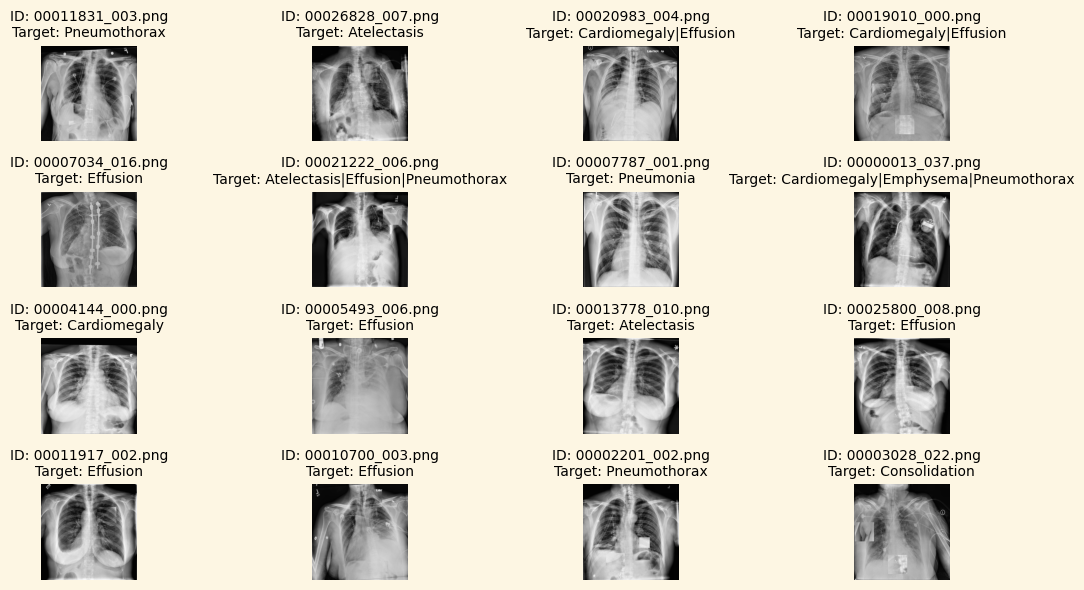

In [15]:
ROWS = 4; COLS = 4; BATCHES = 1


gen = DataGenerator(df_train,batch_size=16, shuffle=False, augment1=True, augment2=True, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping 

EPOCHS = 10

es = EarlyStopping(monitor='val_auc', mode='max', patience=5)
lr = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [17]:
def parent_model():
    inp = layers.Input(shape=(256,256,3))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    base_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    
    base_out = base_model(inp)
    
    x = layers.GlobalAveragePooling2D()(base_out)
    x = layers.Dense(len(PARENT_TARGET), activation='sigmoid', dtype='float32')(x)
    
    # Compile
    model = Model(inputs=inp, outputs=x, name='efficientnet')
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-3)
    label_weights = [1.0] * 4
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

In [18]:
def lung_model():
    inp = layers.Input(shape=(256,256,3))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    base_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    
    base_out = base_model(inp)
    
    x = layers.GlobalAveragePooling2D()(base_out)
    x = layers.Dense(len(LUNG_TARGET), activation='sigmoid', dtype='float32')(x)
    
    # Compile
    model = Model(inputs=inp, outputs=x, name='efficientnet')
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-3)
    label_weights = [1.0] * 6
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

In [19]:
def pleural_model():
    inp = layers.Input(shape=(256,256,3))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    base_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    
    base_out = base_model(inp)
    
    x = layers.GlobalAveragePooling2D()(base_out)
    x = layers.Dense(len(PLEURAL_TARGET), activation='sigmoid', dtype='float32')(x)
    
    # Compile
    model = Model(inputs=inp, outputs=x, name='efficientnet')
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-3)
    label_weights = [1.0] * 2
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

## Train Lung Opacity Model

In [20]:
tmp = df_train[df_train['Finding Labels'].apply(lambda x: all(label in LUNG_TARGET for label in x.split('|')))]
tmp = tmp.reset_index(drop=True)
gkf = GroupKFold(n_splits=5)
for i, (_, valid_index) in enumerate(gkf.split(tmp, groups=tmp['Patient ID'])):
    tmp.loc[valid_index, 'Fold'] = i

**Lung Opacity Model Metric**

In [21]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(tmp[tmp['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=16, preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(tmp[tmp['Fold'] == i], shuffle=False, batch_size=32, preprocess=efn.preprocess_input)
    
    print(f'### train size {len(tmp[tmp["Fold"] != i])}, valid size {len(tmp[tmp["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = lung_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'EffNet_lung_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid Auc'].append(history.history['val_auc'])
        all_history['Train Auc'].append(history.history['auc'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_lung_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(tmp[tmp['Fold'] == i][LUNG_TARGET].values)
    all_index.append(tmp[tmp['Fold'] == i]['Image Index'].values)
    
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

#########################
### Fold 1
### train size 1370, valid size 343
#########################
Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 201s 816ms/step - auc: 0.6873 - loss: 0.4967 - val_auc: 0.7262 - val_loss: 0.4723 - learning_rate: 0.0010
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - auc: 0.7569 - loss: 0.4472
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
86/86 ━━━━━━━━━━━━━━━━━━━━ 53s 579ms/step - auc: 0.7570 - loss: 0.4471 - val_auc: 0.6696 - val_loss: 0.5705 - learning_rate: 0.0010
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 83s 593ms/step - auc: 0.8057 - loss: 0.4185 - val_auc: 0.7693 - val_loss: 0.4520 - learning_rate: 1.0000e-04
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - auc: 0.8325 - loss: 0.4039
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
86/86 ━━━━━━━━━━━━━━━━━━━━ 54s 594ms/step - auc: 0.8323 - loss: 0.4039 - val_auc: 0.7743 - val_loss: 0.4510 - learning_rate: 1.0000e-04
Epoch 5/10
86/86 ━━━━━━━━━

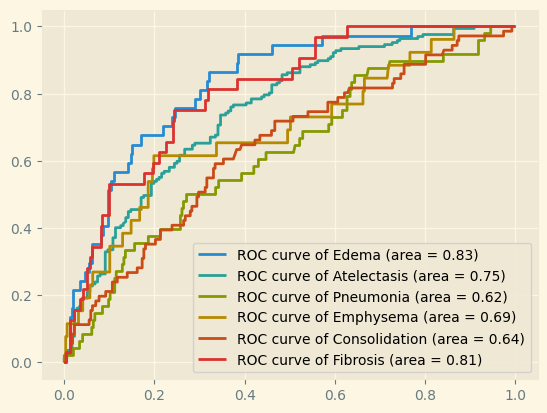

In [22]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(LUNG_TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(LUNG_TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {LUNG_TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()

In [23]:
auc_score = roc_auc_score(all_true, all_oof, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Train Set =', auc_score)

AUC for Train Set = 0.7241141660707949


## Train Pleural Model

In [24]:
tmp = df_train[df_train['Finding Labels'].apply(lambda x: all(label in PLEURAL_TARGET for label in x.split('|')))]
tmp = tmp.reset_index(drop=True)
gkf = GroupKFold(n_splits=5)
for i, (_, valid_index) in enumerate(gkf.split(tmp, groups=tmp['Patient ID'])):
    tmp.loc[valid_index, 'Fold'] = i

In [25]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(tmp[tmp['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=16, preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(tmp[tmp['Fold'] == i], shuffle=False, batch_size=32, preprocess=efn.preprocess_input)
    
    print(f'### train size {len(tmp[tmp["Fold"] != i])}, valid size {len(tmp[tmp["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = pleural_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'EffNet_pleural_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid Auc'].append(history.history['val_auc'])
        all_history['Train Auc'].append(history.history['auc'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_pleural_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(tmp[tmp['Fold'] == i][PLEURAL_TARGET].values)
    all_index.append(tmp[tmp['Fold'] == i]['Image Index'].values)
    
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

#########################
### Fold 1
### train size 878, valid size 220
#########################
Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 173s 836ms/step - auc: 0.6550 - loss: 0.6655 - val_auc: 0.8097 - val_loss: 0.5706 - learning_rate: 0.0010
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 581ms/step - auc: 0.7920 - loss: 0.5809 - val_auc: 0.8459 - val_loss: 0.5187 - learning_rate: 0.0010
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 604ms/step - auc: 0.8108 - loss: 0.5550 - val_auc: 0.8830 - val_loss: 0.5460 - learning_rate: 0.0010
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - auc: 0.8292 - loss: 0.5345
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 577ms/step - auc: 0.8293 - loss: 0.5344 - val_auc: 0.8135 - val_loss: 0.6033 - learning_rate: 0.0010
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - auc: 0.8768 - loss: 0.4694
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
55/55 ━━━━━━━━━━━━━━━━━━

**Pleural Model Metric**

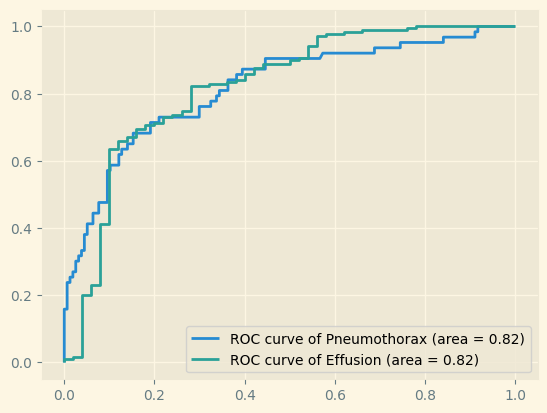

In [26]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(PLEURAL_TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(PLEURAL_TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {PLEURAL_TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()

In [27]:
auc_score = roc_auc_score(all_true, all_oof, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Train Set =', auc_score)

AUC for Train Set = 0.8202016628307374


## Parent Model

In [28]:
gkf = GroupKFold(n_splits=5)
for i, (_, valid_index) in enumerate(gkf.split(df_train, groups=df_train['Patient ID'])):
    df_train.loc[valid_index, 'Fold'] = i

In [29]:
import tensorflow.keras.backend as K

all_parent_oof = []
all_parent_true = []
all_oof = []
all_true = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=32, preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=32, preprocess=efn.preprocess_input)
    
    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = parent_model()
        lung_model = lung_model()
        pleural_model = pleural_model()
     
    if LOAD_MODELS_FROM is None:
        lung_model.load_weights(f'EffNet_lung_f{i}.weights.h5')
        pleural_model.load_weights(f'EffNet_pleural_f{i}.weights.h5')
        
        
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'EffNet_parent_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid Auc'].append(history.history['val_auc'])
        all_history['Train Auc'].append(history.history['auc'])

    else:
        lung_model.load_weights(f'{LOAD_MODELS_FROM}EffNet_lung_f{i}.weights.h5')
        pleural_model.load_weights(f'{LOAD_MODELS_FROM}EffNet_pleural_f{i}.weights.h5')
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_parent_f{i}.weights.h5')
        
        
    oof = model.predict(valid_gen, verbose=1)
    lung_oof = lung_model.predict(valid_gen, verbose=1)
    pleural_oof = pleural_model.predict(valid_gen, verbose=1)
    
    total_oof = np.zeros((len(df_train[df_train["Fold"] == i]),10))
    total_oof[:,0] = oof[:,0]
    total_oof[:,1:7] = oof[:,1:2] * lung_oof
    total_oof[:,7:9] = oof[:,2:3] * pleural_oof
    total_oof[:,9] = oof[:,3]
    
    all_oof.append(total_oof)   
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_parent_oof.append(oof)
    all_parent_true.append(df_train[df_train['Fold'] == i][PARENT_TARGET].values)
    
    del model, lung_model, pleural_model, oof, total_oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_parent_oof = np.concatenate(all_parent_oof)
all_parent_true = np.concatenate(all_parent_true)

#########################
### Fold 1
### train size 3200, valid size 800
#########################
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - auc: 0.7632 - loss: 0.5354 - val_auc: 0.7907 - val_loss: 0.5426 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - auc: 0.8212 - loss: 0.4872
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - auc: 0.8212 - loss: 0.4871 - val_auc: 0.7863 - val_loss: 0.6736 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - auc: 0.8512 - loss: 0.4604 - val_auc: 0.8477 - val_loss: 0.4638 - learning_rate: 1.0000e-04
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - auc: 0.8677 - loss: 0.4418
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
100/100 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - auc: 0.8677 - loss: 0.4419 - val_auc: 0.8471 - val_loss: 0.4649 - learning_rate: 1.0000e-04
Epoch 5/10
100/100 ━━━━

**Parent Metric**

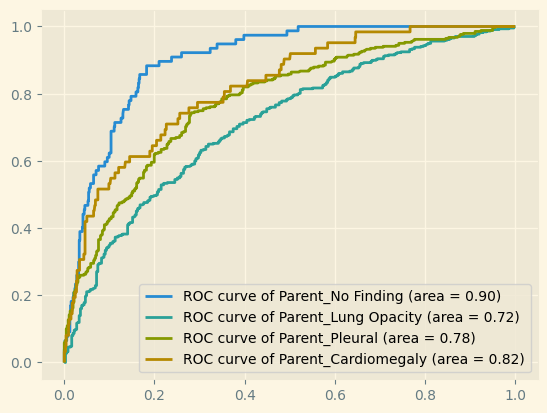

In [30]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(PARENT_TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_parent_true[:, i], all_parent_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(PARENT_TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {PARENT_TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()

In [31]:
auc_score = roc_auc_score(all_parent_true, all_parent_oof, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Train Set =', auc_score)

AUC for Train Set = 0.8038605739056398


**Total Metric**

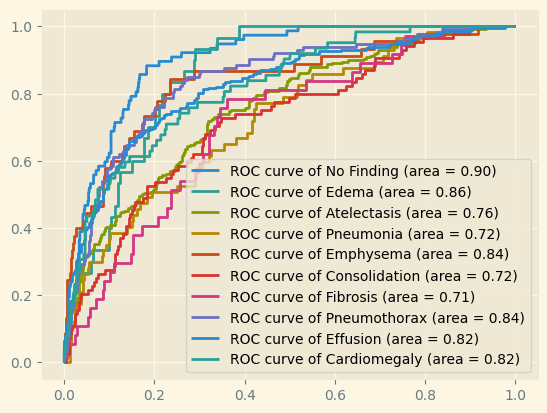

In [32]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()

In [33]:
auc_score = roc_auc_score(all_true, all_oof, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Train Set =', auc_score)

AUC for Train Set = 0.7992648207821054
